# Goals of the analysis

* Cluster meetup tags
* Label the clusters
* Find the mixture of topics in African Meetup groups
* Measure the Revealed Comparative Advantage of African countries in health topics
* Create static visualisations

In [1]:
%load_ext autoreload

In [5]:
%autoreload
%matplotlib inline

import sys
import pickle
import itertools

import gensim
import numpy as np
import pandas as pd
import networkx as nx
from numpy import inf
import matplotlib as mpl
from node2vec import Node2Vec
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

sys.path.append('../src/')
from utils import *
from networks import *
from topic_names import *
from dim_reduction import *
from topic_proportions import *

np.random.seed(42)

## Vector representation of tags

In [6]:
# Read data
groups_members = pd.read_csv('../data/raw/groups_members.csv')

# Using only groups for clustering meetup tags
groups = groups_members.drop_duplicates('group_id')
# groups.reset_index(inplace=True)

# Removed few topics because they were completely unrelated to health
topics_of_interest = ['Tech', 'Career & Business', 'Language & Ethnic Identity', 'Outdoors & Adventure','Health & Wellbeing', 'Education & Learning', 
                      'Food & Drink', 'Arts & Culture', 'Sports & Recreation', 'Community & Environment', 'Fitness', 'Support', 'LGBT', 
                      'Parents & Family', 'Fashion & Beauty']

african_country_codes = ['DZ', 'AO', 'SH', 'BJ', 'BW', 'BF', 'BI', 'CM', 'CV', 'CF', 'TD', 'KM', 'CG', 'CD', 'DJ', 'EG', 'GQ',
                         'ER', 'SZ', 'ET', 'GA', 'GM', 'GH', 'GN', 'GW', 'CI', 'KE', 'LS', 'LR', 'LY', 'MG', 'MW', 'ML', 'MR',
                         'MU', 'YT', 'MA', 'MZ', 'NA', 'NE', 'NG', 'ST', 'RE' 'RW', 'ST', 'SN', 'SC', 'SL', 'SO', 'ZA', 'SH',
                         'SD', 'SZ', 'TZ', 'TG', 'TN', 'UG', 'CD', 'ZM', 'TZ', 'ZW']

groups = groups[(groups.category_name.isin(topics_of_interest)) & (groups.country.isin(african_country_codes))]

print('Number of unique African groups: {}'.format(groups.shape[0]))

/Users/konstantinosstathoulopoulos/anaconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Number of unique African groups: 2175


In [ ]:
# preprocess meetup tags
tags = [[tag.strip() for tag in u.split(',')] for u in list(groups.urlkey)]

# Train a word2vec on the tags
w2v = gensim.models.Word2Vec(tags, size=200, window=5, min_count=2, iter=20)

# w2v.save('../models/v1/w2v.model')

## Cluster vectorised tags 

* Build a matrix (word, vector) with word2vec vectors. 
* Find the cosine distance of the above matrix 
* Reduce its dimensionality to 2D using t-SNE

In [113]:
ts = WrapTSNE(w2v)
tsne_space = ts.reduce_dimensions(2000, 40)

[[0.00000000e+00 6.46630470e-01 5.77280803e-01 ... 8.40586863e-01
  1.00000000e+00 9.78958580e-01]
 [6.46630470e-01 0.00000000e+00 6.19510244e-01 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]
 [5.77280803e-01 6.19510244e-01 0.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 1.00000000e+00]
 ...
 [8.40586863e-01 1.00000000e+00 1.00000000e+00 ... 0.00000000e+00
  3.75679977e-01 4.02188689e-01]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 ... 3.75679977e-01
  0.00000000e+00 4.23996547e-01]
 [9.78958580e-01 1.00000000e+00 1.00000000e+00 ... 4.02188689e-01
  4.23996547e-01 8.88178420e-16]]
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 12966 samples in 0.062s...
[t-SNE] Computed neighbors for 12966 samples in 2.120s...
[t-SNE] Computed conditional probabilities for sample 1000 / 12966
[t-SNE] Computed conditional probabilities for sample 2000 / 12966
[t-SNE] Computed conditional probabilities for sample 3000 / 12966
[t-SNE] Computed conditional probabilities for sample 4

In [117]:
## Clustering with GMM
# Instantiate the class using the 2D space from t-SNE
gmm_eval = GME(tsne_space)

best_gmm, bic = gmm_eval.fit_eval(max_components=80)
print('BEST GMM MODEL: {}'.format(best_gmm))

BEST GMM MODEL: GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=49, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)


In [118]:
# Keep words and vectors separately.
dict_keys, dict_values = ts.unravel_dictionary(ts.word_vectors())

# Predict token clusters based on best_gmm
token_labels = best_gmm.predict(tsne_space)

# Create a list of tuples: [(token, cluster)] that will be used to classify Meetup groups
clustered_tokens = [tuple((dict_keys[i], token_labels[i])) for i in range(len(dict_keys))]

In [540]:
# Example
topic_tokens(clustered_tokens, 3)[:5]

['real-estate-investors',
 'real-estate-investment',
 'multifamily-investing',
 'real-estate',
 'real-estate-investing']

## Assigning topics to Meetup groups

* Filter out tags with a low TF-IDF value.
* Assign topics to Meetup groups based on their tags.

In [ ]:
tp = TopicProportions()
useless_tokens = tp.wrapper(tags)

elements = tp.remove_items(tags, set(useless_tokens))
groups['reduced_tags'] = elements

# Find the topic proportions
group_labels = tp.find_token_labels(groups, clustered_tokens)
df_topics_proportions = tp.topic_proportions(groups, group_labels)
df_final = groups.merge(df_topics_proportions, left_on='name', right_on='index')
df_final.rename(index=str, inplace=True, columns=topic_names_v2)

In [ ]:
## Storing data
# df_final.to_csv('../models/v1/df_with_labelled_topics.csv')

# with open('../models/v1/gmm.pickle', 'wb') as h:
#     pickle.dump(best_gmm, h)

# with open('../models/v1/bic.pickle', 'wb') as h:
#     pickle.dump(bic, h)

# with open('../models/v1/tsne_space.pickle', 'wb') as h:
#     pickle.dump(tsne_space, h)

# with open('../models/v1/token_labels.pickle', 'wb') as h:
#     pickle.dump(token_labels, h)

# with open('../models/v1/dict_keys.pickle', 'wb') as h:
#     pickle.dump(dict_keys, h)

# with open('../models/v1/dict_values.pickle', 'wb') as h:
#     pickle.dump(dict_values, h)

# with open('../models/v1/clustered_tokens.pickle', 'wb') as h:
#     pickle.dump(clustered_tokens, h)

## Analysis of health Meetups

* Decide (subjectively) which categories are about health. 
* Keep only groups that are at least 25% health
* 

In [108]:
health_cats = ['Family & Support', 'Outdoors activities', 'Alternative Wellbeing', 'Exercise & Fitness', 'Self improvement & Spirituality', 
               'Health', 'Self-empowerment', 'Peer Support', 'Eating healthy']

all_topics = ['Family & Support', 'UX & Usability', 'Outdoors activities', 'Real Estate', 'DevOps', 'Language', 'Big data', 'Alternative Wellbeing', 
              'Sports', 'Entrepreneurship', 'Digital Marketing', 'Community Service', 'Travelling', 'Self improvement', 'Art', 'Mobile Development', 
              'Finance', 'LGBTQ', 'Freelancing & Startups', 'PaaS & Security', 'Exercise & Fitness', 'IoT & Smart Sensors', 'Cryptocurrencies', 
              'Social activities', 'Immersive Reality & Video Games', 'Sustainable Development', 'Web Development', 'International Communities', 
              'Performing arts', 'Self improvement & Spirituality', 'International cuisine', 'Outdoor adventures', 'Education & Networking', 'Google Apps',
              'Content Management Platforms', 'Health', 'Fashion', 'AI & Robotics', 'Self-empowerment', 'Eating healthy', 'Marketing & Business strategy', 
              'Socialising', 'Recruiting & Management', 'Peer Support', 'Programming']

all_topics_non_health = set(all_topics) - set(health_cats)

In [109]:
# Keep only groups that have a topic mix with at least 25% health
health_ids = [idx for idx, row in df_final.iterrows() if row[health_cats].sum() > .25]
health_meetups = df_final[df_final.country.isin(african_country_codes)].loc[health_ids, :]

/Users/konstantinosstathoulopoulos/anaconda3/envs/py36/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [110]:
# Subset the main dataset by health meetups and african countries
hgm = groups_members[(groups_members.group_id.isin(health_meetups.group_id.unique())) & (groups_members.country.isin(african_country_codes))]

# Merge the hgm with the topics 
hgm_topics = hgm.merge(health_meetups[['Family & Support', 'Outdoors activities', 'Alternative Wellbeing', 'Community Service', 'Exercise & Fitness', 
                                       'Self improvement & Spirituality', 'Health', 'Self-empowerment', 'Peer Support', 'Eating healthy', 'group_id']], 
                       left_on='group_id', right_on='group_id')

print('Number of unique memberships in health meetups: {}'.format(hgm.drop_duplicates('member_id').shape[0]))

# Save data
# hgm_topics.to_csv('../data/outputs/health_groups_members.csv')

Number of unique memberships in health meetups: 30986


In [68]:
health_groups_prop = health_meetups[health_meetups.country.isin(african_country_codes)].drop_duplicates('group_id').year.value_counts() / groups[groups.country.isin(african_country_codes)].drop_duplicates('group_id').year.value_counts()

/Users/konstantinosstathoulopoulos/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in greater


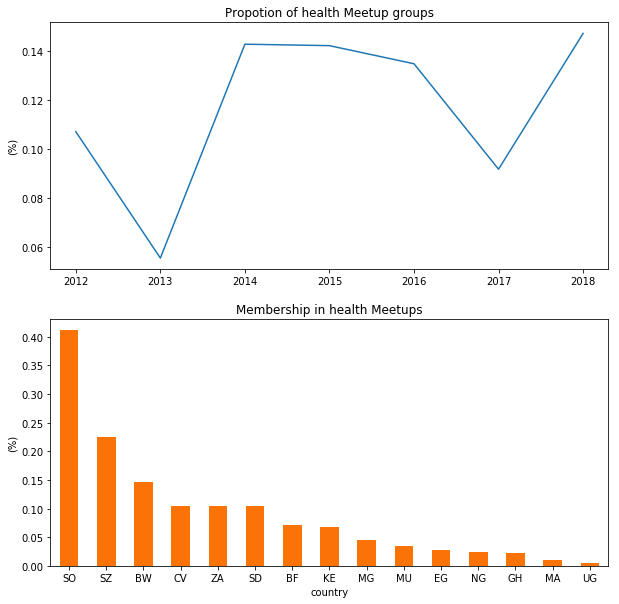

In [72]:
f, (ax1,ax2) = plt.subplots(nrows=2, figsize=(10,10))

# ax1
health_groups_prop.dropna().plot(ax=ax1, title='Propotion of health Meetup groups')
ax1.set_ylabel('(%)')

# ax2
# proportion of members subscribed to health groups
m = hgm.groupby('country').count()['member_id'] / groups_members.groupby('country').count()['member_id']
m[m.values > 0].sort_values(ascending=False)[:15].plot(kind='bar', title='Membership in health Meetups', color='xkcd:orange', rot=0, ax=ax2)
ax2.set_ylabel('(%)')

plt.show()

/Users/konstantinosstathoulopoulos/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: divide by zero encountered in log


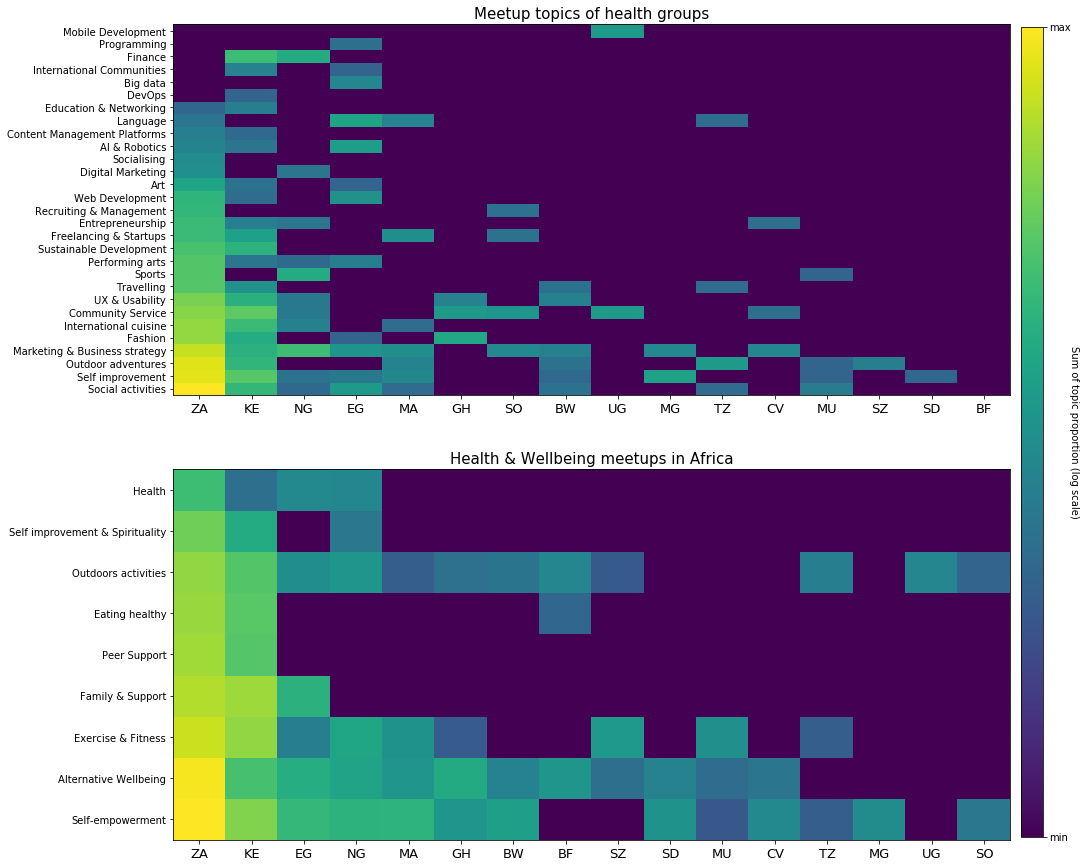

In [62]:
def graph_input(df, topics):
    health_sub_topics = df.loc[:,topics]
    health_sub_topics['country'] = df.country
    hst = health_sub_topics.groupby('country').sum().T
    hst = hst.loc[(hst != 0).any(axis=1), :]
    idx = hst.sum().sort_values(ascending=False).index
    val = hst[idx[0]].sort_values(ascending=False).index
    return hst, idx, val

df1, idx1, val1 = graph_input(health_meetups, all_topics_non_health)
df2, idx2, val2 = graph_input(health_meetups, health_cats)

def plot_matrix(df, idx, val, title, ax):
    df = np.log(df.loc[val, idx])
    df[df == -inf] = -5
    ax.pcolor(df)
    ax.set_yticks(np.arange(0.5, len(df.loc[val, idx].index), 1))
    ax.set_yticklabels(df.loc[val, idx].index)
    ax.set_xticks(np.arange(0.5, len(df.loc[val, idx].columns), 1))
    ax.set_xticklabels(df.loc[val, idx].columns)
    ax.xaxis.set_tick_params(labelsize=13)
    ax.set_title(title, fontsize=15)
    
def colourbar(fig, cb_title):
    cax = fig.add_axes([0.91, 0.128, 0.02, 0.75])
    cb = mpl.colorbar.ColorbarBase(cax, cmap=plt.cm.viridis, spacing='proportional', ticks=[-1, 0, 1])
    cb.ax.set_yticklabels(['min', 'max']) 
    cb.set_label(cb_title, labelpad=8, rotation=270)

    
f, (ax1, ax2) = plt.subplots(nrows=2, figsize=(15,15))

plot_matrix(df1, idx1, val1, 'Meetup topics of health groups', ax=ax1)
plot_matrix(df2, idx2, val2, 'Health & Wellbeing meetups in Africa', ax=ax2)
colourbar(f, 'Sum of topic proportion (log scale)')

plt.show()

## Measure the comparative advantage of African countries in health meetups

In [73]:
# Keep only countries with more than 20 groups
countries = [country for country in df_final.country.unique() 
             if df_final[df_final['country']==country].shape[0] > 20 
             and country in african_country_codes]
d = {}
for country in countries:
    rca_topic = {}
    for topic in health_cats:
        try:
            cx = df_final[(df_final[topic] > 0) & (df_final['country']==country)].shape[0]
            cy = df_final[(df_final['country']==country)].shape[0]

            xall = df_final[(df_final[topic] > 0) & (df_final.country.isin(countries))].shape[0]
            yall = df_final[(df_final.country.isin(countries))].shape[0]

            rca = (cx / cy) / (xall / yall)

        except ZeroDivisionError as e:
            rca = 0

        rca_topic[topic] = rca

    d[country] = rca_topic
    
k = pd.DataFrame(d)
func = lambda x: 5 if x > 5 else x
for col in k.columns:
    k.loc[:, col] = k[col].apply(func)

groups_rca = k.loc[:, k.median().sort_values(ascending=False).index]

In [80]:
import seaborn as sns

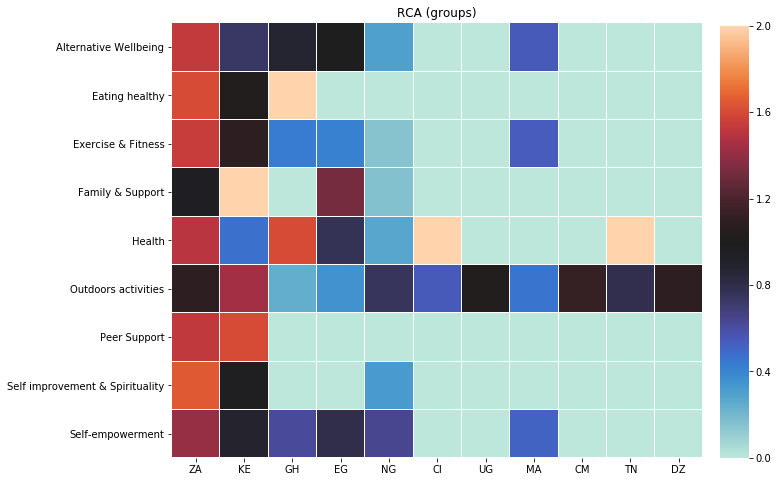

In [93]:
cmap = sns.diverging_palette(255, 133, l=60, n=7, center="dark", as_cmap=True)

fig, (ax1) = plt.subplots(figsize=(10,8))
cbar_ax = fig.add_axes([.905, .125, .04, .75])
sns.heatmap(groups_rca, vmax=2, center=1, linewidths=0.01, cbar=True, square=True,annot=False,linecolor="white", ax=ax1, cbar_ax=cbar_ax)
ax1.set_title('RCA (groups)', fontsize=12)

plt.show()

## Country co-occurrence

In [136]:
%%time
country_cooc = hgm[hgm.country.isnull()==False][['member_id', 'country']].groupby('member_id')['country'].agg(lambda col: ', '.join(col))

CPU times: user 393 ms, sys: 6.82 ms, total: 399 ms
Wall time: 398 ms


In [151]:
country_cooc = pd.DataFrame(country_cooc)
country_cooc['cc'] = country_cooc.country.apply(lambda x: list(set([elem.strip() for elem in x.split(',')])))
cooc_graph = cooccurrence_graph(list(country_cooc['cc']))

G = nx.Graph()
for unique_country, dictionary in cooc_graph.items():
    for k,v in dictionary.items():
        G.add_edge(unique_country, k, weight=int(v))
        
for n in G.nodes:
    G.node[n]['lat'] = df_final[df_final.country==n]['lat'].iloc[0]
    G.node[n]['lng'] = df_final[df_final.country==n]['lon'].iloc[0]
    
nx.write_graphml(G, '../models/v1/countries_connections.graphml')